In [36]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN


In [37]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

### Monthly Data

In [38]:
conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)
data['Date'] = pd.to_datetime(data['Date'])
# data['Date'] = data["Date"].dt.to_period("M").astype(str)
data['Station_ID'] = data['Station_ID'].astype(str)

conn.close()

In [39]:
data

,Station_ID,Station_Name,Province,Station_Latitude,Station_Longitude,Station_Elevation,Date,Temperature_Maximum,Temperature_Minimum,Temperature,...,ERA5_SPI_24,ERA5_SPEI_24,GPM_SPI_24,GPM_SPEI_24,TRMM_SPI_24,TRMM_SPEI_24,TERRACLIMATE_SPI_24,TERRACLIMATE_SPEI_24,PERSIANNCDR_SPI_24,PERSIANNCDR_SPEI_24
0,40709,Astara,Gilan,38.365,48.855,-21.1,2006-09-01,25.6,18.4,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40709,Astara,Gilan,38.365,48.855,-21.1,2006-10-01,22.2,16.7,19.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40709,Astara,Gilan,38.365,48.855,-21.1,2006-11-01,16.6,8.2,12.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40709,Astara,Gilan,38.365,48.855,-21.1,2006-12-01,10.3,2.5,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40709,Astara,Gilan,38.365,48.855,-21.1,2007-01-01,12.8,2.4,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,99361,Alasht,Mazandaran,36.071,52.843,1805.0,2024-02-01,7.5,-1.3,3.1,...,-1.495,NaN,-0.884,NaN,NaN,NaN,NaN,NaN,-5.877,NaN
5132,99361,Alasht,Mazandaran,36.071,52.843,1805.0,2024-03-01,12.1,1.8,6.9,...,-1.630,NaN,-1.944,NaN,NaN,NaN,NaN,NaN,-6.136,NaN
5133,99361,Alasht,Mazandaran,36.071,52.843,1805.0,2024-04-01,15.7,6.2,10.9,...,-1.800,NaN,-1.772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5134,99361,Alasht,Mazandaran,36.071,52.843,1805.0,2024-05-01,18.0,9.3,13.6,...,-1.602,NaN,-0.695,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare the Data

In [40]:

data = data.query('Province == "Mazandaran"')


# Aggregate the data by station
station_data = data.groupby(["Station_ID", "Station_Name", data["Date"].dt.year]).agg({
    'Temperature': 'mean',
    'Temperature_Maximum': 'mean',
    'Temperature_Minimum': 'mean',
    'Precipitation': 'sum',
    'Station_Elevation': 'first',
}).groupby(["Station_ID", "Station_Name"]).agg({
    'Temperature': 'mean',
    'Temperature_Maximum': 'mean',
    'Temperature_Minimum': 'mean',
    'Precipitation': 'mean',
    'Station_Elevation': 'first',
}).reset_index()

station_data['DT'] = station_data['Temperature_Maximum'] - station_data['Temperature_Minimum']

# Normalize the data
scaler = StandardScaler()
features = ["Temperature", "Precipitation", "Station_Elevation", "DT"]
station_data_scaled = scaler.fit_transform(station_data[features])

### Apply Clustering Algorithm

##### K-Means Clustering

In [41]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=42)

station_data['Cluster'] = kmeans.fit_predict(station_data_scaled)
station_data['Cluster'] = station_data['Cluster'] + 1


station_data.Cluster.value_counts()

Cluster
1    8
2    5
3    2
Name: count, dtype: int64

In [42]:
station_data['Cluster'] = station_data['Cluster'].astype(str)
fig = px.scatter(
    station_data,
    x="Temperature",
    y="Precipitation",
    color="Cluster",  # This is equivalent to `hue="Cluster"` in seaborn
    color_continuous_scale="Viridis",  # Set the color palette to 'Viridis'
    hover_name=station_data['Station_Name'],
    height=600,
    width=600
)

fig.update_traces(
    marker=dict(size=8)
)

fig.update_layout(
    template="plotly_white",
    # bordercolor='black',
    # title={
    #     'text': "دمای متوسط در مقابل مجموع بارش بر اساس خوشه‌ها",
    #     'x': 0.5,  # Center the title
    #     'xanchor': 'center',
    #     'yanchor': 'top',
    #     'font': {'size': 24, 'family': 'B Zar'}  # Change title font and size
    # },
    xaxis_title="(درجه سانتیگراد) دمای متوسط",
    yaxis_title="بارش (میلیمتر)",
    font={
        'family': 'B Zar',
        'size': 24
    },
    legend_title="خوشه‌ها",
    legend=dict(
        font=dict(
            size=18
        )
    ),
    # xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    # yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.update_layout(
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        linecolor='black',
        linewidth=1,
        ticks='inside',
        ticklen=6,
        tickwidth=1, 
        dtick=1
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        linecolor='black',
        linewidth=1,
        ticks='inside',
        ticklen=6,
        tickwidth=1,
        dtick=150
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    shapes=[
        dict(
            type="rect",
            x0=0,
            x1=1,
            y0=0,
            y1=1,
            xref="paper",
            yref="paper",
            line=dict(
                color="black",
                width=2
            )
        )
    ]
)

fig.show()

In [74]:
import plotly.graph_objects as go

# Assuming 'station_data' DataFrame is already loaded and processed
station_data['Cluster'] = station_data['Cluster'].astype(int)

# Define custom colors for each cluster (you can choose your own colors)
custom_colors = {
    1: 'red',     # Cluster 1 gets blue
    2: 'green',    # Cluster 2 gets green
    3: 'blue'    # Cluster 3 gets orange
}

# Assign custom colors based on the 'Cluster' column
colors = [custom_colors.get(cluster, 'gray') for cluster in station_data['Cluster']]

# Define marker shapes for each cluster (you can define more shapes or customize)
cluster_shapes = {
    1: 'square',  # Cluster 1 gets square markers
    2: 'circle',  # Cluster 2 gets diamond markers
    3: 'cross'  # Cluster 3 gets cross markers
}

# Define the shape list based on the Cluster
shapes = [cluster_shapes.get(cluster, 'circle') for cluster in station_data['Cluster']]

# Create the 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=round(station_data["Temperature"], 1),
            y=round(station_data["Precipitation"], 1),
            z=round(station_data["Station_Elevation"], 1),
            mode="markers",
            marker=dict(
                size=8,
                color=colors,  # Custom colors for clusters
                symbol=shapes,  # Custom shapes for each cluster
                opacity=0.8,  # Marker transparency (optional)
            ),
            text=station_data["Station_Name"],
            hovertemplate=(
                'Station: %{text}<br>'
                'Temperature: %{x}<br>'
                'Precipitation: %{y}<br>'
                'Elevation: %{z}<br>'
                '<extra></extra>'
            )
        )
    ]
)

# Set the title and labels for axes
fig.update_layout(

    scene=dict(
        xaxis_title="دمای متوسط (درجه سانتیگراد)",
        yaxis_title="بارندگی (میلیمتر)",
        zaxis_title="ارتفاع ایستگاه (متر)",
        # xaxis=dict(
        #     autorange='reversed'  # Reverse the x-axis direction (greater to lower)
        # ),
        # yaxis=dict(
        #     autorange='reversed'  # Reverse the y-axis direction (greater to lower)
        # ),
    ),
    width=800,  # Optional: Adjust the width of the plot
    height=800,
    margin=dict(l=0, r=0, t=0, b=0),
    font={
        'family': 'B Zar',
        'size': 18
    },
)

# Show the plot
fig.show()


In [75]:
geo_info_map = station_data.merge(data[['Station_ID', 'Province', 'Station_Latitude', 'Station_Longitude']], on='Station_ID', how='left').drop_duplicates(subset=['Station_ID']).reset_index(drop=True)

geo_info_map['Cluster'] = geo_info_map['Cluster'].astype(str)

geo_info_map['Hover_Info'] = geo_info_map.apply(
    lambda row: f"""
    Station Name: <b>{row['Station_Name']}</b><br>
    Station ID: <b>{row['Station_ID']}</b><br>
    Province: <b>{row['Province']}</b><br>
    Latitude: <b>{row['Station_Latitude']}</b><br>
    Longitude: <b>{row['Station_Longitude']}</b><br>
    Elevation: <b>{row['Station_Elevation']} m</b><br>
    Temperature: <b>{round(row['Temperature'], 1)}</b><br>
    Precipitation: <b>{round(row['Precipitation'], 1)}</b><br>
    DT: <b>{round(row['DT'], 1)}</b><br>
    """,
    axis=1
)

shapefile_path = "./assets/geo_data/Iran_1400/Ostan.shp"
gdf = gpd.read_file(shapefile_path)
geojson = gdf.to_crs(epsg=4326).__geo_interface__

cluster_colors = {
    "1": "darkred",
    "2": "darkblue",
    "3": "darkgreen",
}

fig = px.scatter_mapbox(
    geo_info_map,
    lat=geo_info_map.Station_Latitude,
    lon=geo_info_map.Station_Longitude,
    # size="Cluster",
    color="Cluster",
    color_discrete_map=cluster_colors,
    hover_name=geo_info_map['Station_Name'],
    hover_data={'Station_ID': True, 'Station_Name': False, 'Hover_Info': False},
    custom_data=['Hover_Info'],
    text="Station_Name",
    zoom=7.5,
    height=600,
    width=1200
)


# fig.update_layout(
#     mapbox=dict(
#         layers=[
#             {
#                 "source": geojson,
#                 "type": "line",  # "fill" for filled polygons
#                 "color": "black",
#                 "line": {"width": 2},
#                 "below": "traces"
#             }
#         ],
#     )
# )

# Add map style
fig.update_layout(
    # mapbox_style="open-street-map",
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        },
        {
            "source": geojson,
            "type": "line",
            "color": "white",
            "line": {"width": 4},
            "below": "traces"
        }
    ],
    margin={"r":0,"t":0,"l":0,"b":0},
    hoverlabel=dict(        
        bgcolor="white",
        font_size=16,
        font_family="Arial",
        align="left"
    ),
    legend=dict(
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=0.01,
        title="",
        traceorder="normal",
        title_font_family="Times New Roman",
        font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        ),
        bgcolor="snow",
        bordercolor="Black",
        borderwidth=0.5
    )
)

fig.update_traces(textfont_size=14, textposition="top right", textfont_color="black") 

fig.update_traces(
    hovertemplate="%{customdata[0]}",
    marker=dict(size=20)
)

# Show the plot
fig.show()

Cluster 3: Ramsar
Cluster 2: Baladeh  
Cluster 1: Sari 

In [76]:
geo_info_map

,Station_ID,Station_Name,Temperature,Temperature_Maximum,Temperature_Minimum,Precipitation,Station_Elevation,DT,Cluster,Province,Station_Latitude,Station_Longitude,Hover_Info
0,40732,Ramsar,17.272807,20.396930,14.143421,1222.457895,-20.0,6.253509,3,Mazandaran,36.905,50.684,\n Station Name: <b>Ramsar</b><br>\n Sta...
1,40734,Nowshahr,17.106140,20.520614,13.699123,1263.907368,-20.9,6.821491,3,Mazandaran,36.661,51.466,\n Station Name: <b>Nowshahr</b><br>\n S...
2,40735,Siahbisheh,11.159211,15.782895,6.531579,500.231579,1855.4,9.251316,2,Mazandaran,36.231,51.303,\n Station Name: <b>Siahbisheh</b><br>\n ...
3,40736,Babolsar,18.222807,21.776754,14.675877,824.827368,-21.0,7.100877,1,Mazandaran,36.699,52.643,\n Station Name: <b>Babolsar</b><br>\n S...
4,40737,Gharakhil,17.604825,22.495614,12.707018,654.970000,14.7,9.788596,1,Mazandaran,36.487,52.108,\n Station Name: <b>Gharakhil</b><br>\n ...
5,40759,Sari,18.416228,23.222807,13.617544,705.675263,23.0,9.605263,1,Mazandaran,36.536,52.998,\n Station Name: <b>Sari</b><br>\n Stati...
6,40760,Kiyasar,13.489474,18.585088,8.396053,501.895789,1294.3,10.189035,2,Mazandaran,36.248,53.546,\n Station Name: <b>Kiyasar</b><br>\n St...
7,40788,Sari (dasht-e-naz airport),17.798684,22.761404,12.835526,602.572632,16.7,9.925877,1,Mazandaran,36.640,53.195,\n Station Name: <b>Sari (dasht-e-naz airpo...
8,99299,Galugah,17.671491,22.702193,12.636842,536.922632,-10.0,10.065351,1,Mazandaran,36.738,53.837,\n Station Name: <b>Galugah</b><br>\n St...
9,99306,Bandar-e-amirabad,17.824123,21.648246,14.002632,588.898947,-20.0,7.645614,1,Mazandaran,36.856,53.386,\n Station Name: <b>Bandar-e-amirabad</b><b...


##### Hierarchical Clustering

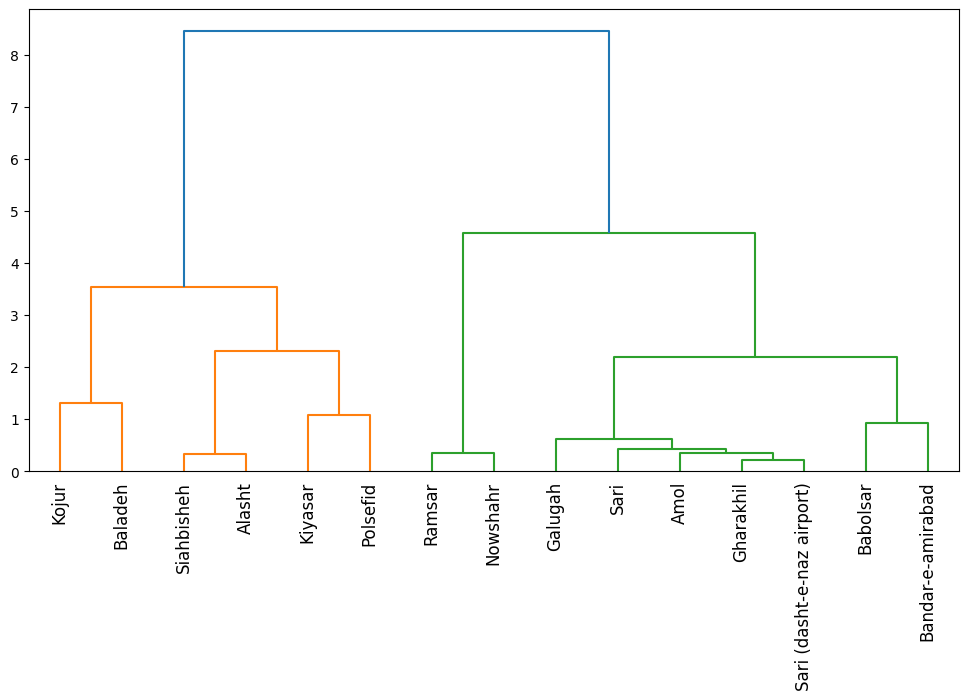

In [77]:
# Perform hierarchical clustering
Z = linkage(station_data_scaled, method='ward')

# Visualize dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=station_data['Station_Name'].values)
plt.xticks(rotation=90)
plt.show()

In [80]:
geo_info_map['Cluster'] = geo_info_map['Cluster'].astype(str)
geo_info_map = geo_info_map.sort_values('Cluster').reset_index(drop=True)
geo_info_map = geo_info_map.round(2)
geo_info_map.drop(columns=['Hover_Info'], inplace=True)
geo_info_map.to_csv('./assets/data/clustering_stations.csv', index=False)